In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

import pickle

from arviz import psislw

from amortizer import amortizer, trainer
from src.models.HmmEam import unconstrain_parameters

from pandas import read_csv

from cmdstanpy import CmdStanModel
from logging import getLogger

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

from helpers import compute_true_log_prob, get_bayesflow_samples, get_stan_samples

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 400, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints/amortizer/history_100.pkl.
INFO:root:Networks loaded from checkpoints/amortizer/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [2]:
stan_model = CmdStanModel(stan_file="../../stan/hmm-eam.stan")

In [8]:
with open(os.path.join('dutilh-resources', 'psis') + '.pkl', 'rb') as f:
    psis=pickle.load(f)

In [37]:
subject = "subject-b"


(pareto_weights, pareto_k) = psis[subject]
pareto_weights = np.exp(pareto_weights)
bf_posterior_constrained, _ = get_bayesflow_samples(subject)
stan_posterior, stan_fit = get_stan_samples(subject)

In [38]:
def weighted_quantile(data, quantiles, weights=None, axis=None):
    """
    Compute weighted quantiles along a specified axis.
    
    Parameters:
    - data: array-like, the data points, can be multi-dimensional.
    - quantiles: array-like or float, quantiles to compute (0 <= quantile <= 1)
    - weights: array-like, weights for each data point, must be broadcastable to `data`.
    - axis: int, the axis along which to calculate quantiles. If None, the entire array is flattened.
    
    Returns:
    - Array of quantiles corresponding to the input quantiles along the specified axis.
    """
    data = np.asarray(data)
    quantiles = np.atleast_1d(quantiles)
    
    if weights is None:
        weights = np.ones_like(data)
    else:
        weights = np.asarray(weights)

    # Flatten if axis is None
    if axis is None:
        data = data.ravel()
        weights = weights.ravel()
        sorter = np.argsort(data)
        data_sorted = data[sorter]
        weights_sorted = weights[sorter]
        
        weighted_cumsum = np.cumsum(weights_sorted)
        cumulative_distribution = weighted_cumsum / weighted_cumsum[-1]
        
        return np.interp(quantiles, cumulative_distribution, data_sorted)
    
    # Move axis to the last dimension for easier manipulation
    data = np.moveaxis(data, axis, -1)
    weights = np.moveaxis(weights, axis, -1)
    
    # Output array for the quantiles along the specified axis
    output_shape = data.shape[:-1] + quantiles.shape
    quantile_values = np.empty(output_shape)
    
    # Iterate over each "slice" along the specified axis
    for idx in np.ndindex(data.shape[:-1]):
        d = data[idx]
        w = weights[idx]
        
        sorter = np.argsort(d)
        d_sorted = d[sorter]
        w_sorted = w[sorter]
        
        weighted_cumsum = np.cumsum(w_sorted)
        cumulative_distribution = weighted_cumsum / weighted_cumsum[-1]
        
        # Compute the quantiles for this slice
        quantile_values[idx] = np.interp(quantiles, cumulative_distribution, d_sorted)
    
    return quantile_values

In [39]:
np.tile(pareto_weights[...,np.newaxis], [1, 8]).shape

(4000, 8)

In [47]:
bf_summary = np.quantile(bf_posterior_constrained, q=[0.25, 0.5, 0.75], axis=0)

bf_summary.transpose()

array([[0.81494041, 0.83706266, 0.85752156],
       [0.89802672, 0.91129568, 0.92216726],
       [0.54154158, 0.59219605, 0.64885466],
       [1.77536628, 1.83388233, 1.89594609],
       [6.24794662, 6.69316697, 7.16236413],
       [2.05940413, 2.22133255, 2.38443643],
       [4.54045141, 4.69946814, 4.86054373],
       [0.15805977, 0.1619685 , 0.16517331]])

In [50]:
bf_weighted_summary =weighted_quantile(bf_posterior_constrained, quantiles=[0.25, 0.5, 0.75], weights=np.tile(pareto_weights[...,np.newaxis], [1, 8]), axis=0)

bf_weighted_summary

array([[0.82310733, 0.84516765, 0.86488068],
       [0.8972224 , 0.9097957 , 0.92011387],
       [0.5608976 , 0.60492218, 0.65757821],
       [1.73798321, 1.80164185, 1.86562208],
       [6.4398437 , 6.95409678, 7.44335681],
       [1.96821962, 2.13216524, 2.328336  ],
       [4.45141194, 4.60908118, 4.78137315],
       [0.1607177 , 0.16387721, 0.16667608]])

In [51]:
stan_summary = np.quantile(stan_posterior, q=[0.25, 0.5, 0.75], axis=0)

stan_summary.transpose()

array([[0.81549875, 0.8368005 , 0.8565375 ],
       [0.892785  , 0.9063045 , 0.918711  ],
       [0.59447425, 0.637871  , 0.6883675 ],
       [1.769865  , 1.825405  , 1.884475  ],
       [6.7258575 , 7.183355  , 7.6277625 ],
       [2.019365  , 2.17583   , 2.34832   ],
       [4.502875  , 4.662445  , 4.81598   ],
       [0.15753725, 0.160889  , 0.16370075]])

In [52]:
np.average(bf_posterior_constrained, axis=0)

array([0.8353144 , 0.90955687, 0.5995621 , 1.8362081 , 6.6981845 ,
       2.2226598 , 4.699826  , 0.16116814], dtype=float32)

In [53]:
np.average(bf_posterior_constrained, axis=0, weights=pareto_weights)

array([0.84284277, 0.9082995 , 0.61198295, 1.80576722, 6.9663165 ,
       2.13913637, 4.62469883, 0.16350607])

In [54]:
np.average(stan_posterior, axis=0)

array([0.83487693, 0.90529691, 0.64435895, 1.8285609 , 7.17928058,
       2.18130065, 4.6612095 , 0.16027329])

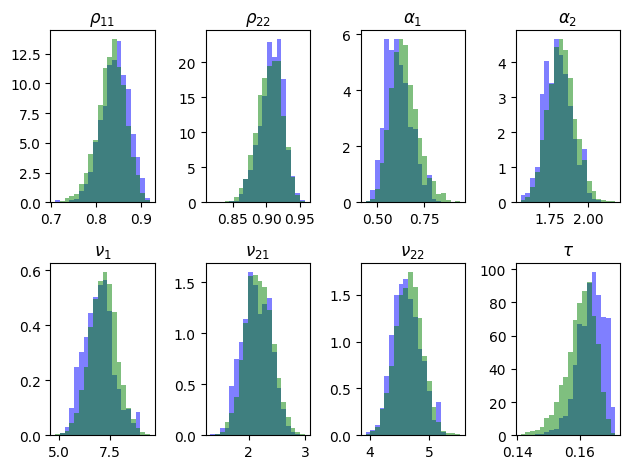

In [76]:
fig, axs = plt.subplots(2, 4)
axs = axs.flatten()

for i in range(8):
    bins = np.linspace(np.min(stan_posterior[:,i]), np.max(stan_posterior[:,i]), 21)

    #axs[i].hist(bf_posterior_constrained[:,i], density=True, bins=bins, color="gray", alpha=0.5)
    axs[i].hist(bf_posterior_constrained[:,i], density=True, bins=bins, color="blue", alpha=0.5, weights=pareto_weights)
    axs[i].hist(stan_posterior[:,i], density=True, bins=bins, color="green", alpha=0.5)
    axs[i].set_title(trainer.generative_model.param_names['constrained'][i])

fig.tight_layout()

In [62]:
bins

NameError: name 'bins' is not defined